In [14]:
import pandas as pd
from pandas import DataFrame
from pandas.tseries.offsets import DateOffset
import numpy as np
from pandas.plotting import autocorrelation_plot
import pandas.util.testing as tm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from numpy import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Leitura do CSV e setando como Time
df = pd.read_csv('FT02_18_19.csv',delimiter=';', parse_dates=True)
df['Time'] = pd.to_datetime(df.Time)
df = df[df['Time'].notna()]
df = df.set_index('Time')
df = df.resample("D").last()

In [16]:
#Separar dados de treino e teste
dias = 31
train = df.iloc[:-dias,0:1].copy()
test = df.iloc[-dias:,0:1].copy()

history = [train.iloc[i,0] for i in range(len(train))]
predictions = []

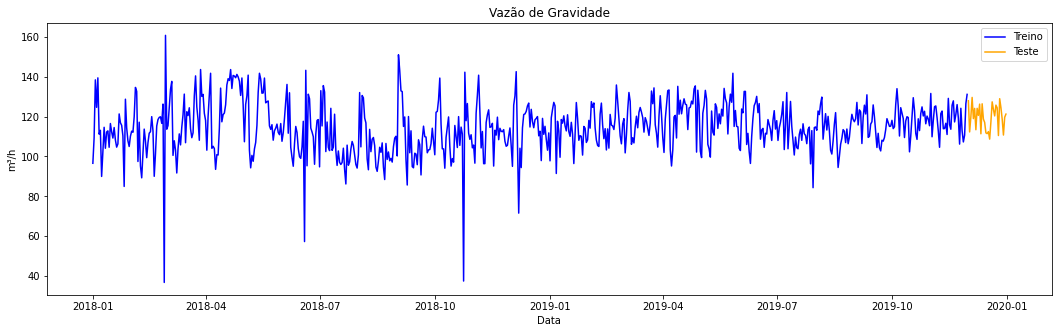

In [17]:
# Visualização das amostras de treino e teste
plt.figure(figsize=(18,5))
plt.title('Vazão de Gravidade')
plt.plot(train['Vazao02'], color='b')
plt.plot(test['Vazao02'], color='orange')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('m³/h')
plt.show()

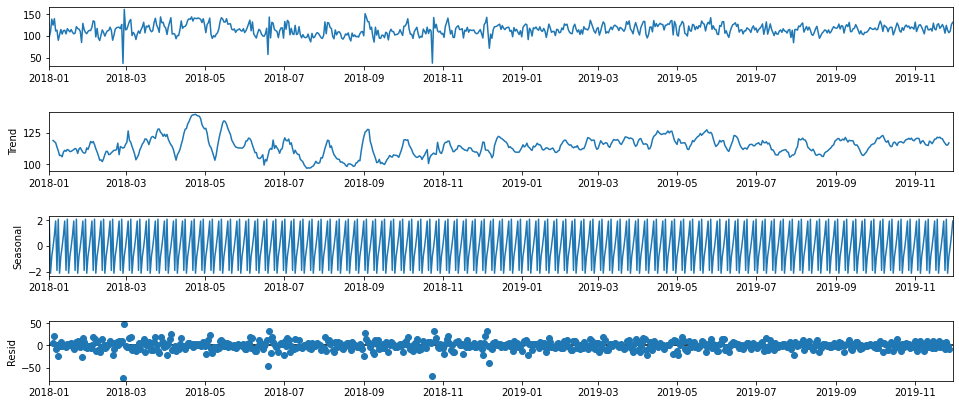

In [18]:
#Verificando Residuais, Sazonalidade e Tendencias
result = seasonal_decompose(train, freq=7)
fig = result.plot()
fig.set_size_inches(15,6)

In [19]:
#Verificando atraves de Dickey Fuller a estacionariedade
X = df.values
result = adfuller(X)
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(-6.516358527194385, 1.0689057282523643e-08, 7, 722, {'1%': -3.439439614524914, '5%': -2.865551414233055, '10%': -2.5689061365397747}, 5497.581949546244)
ADF Statistic: -6.516359
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


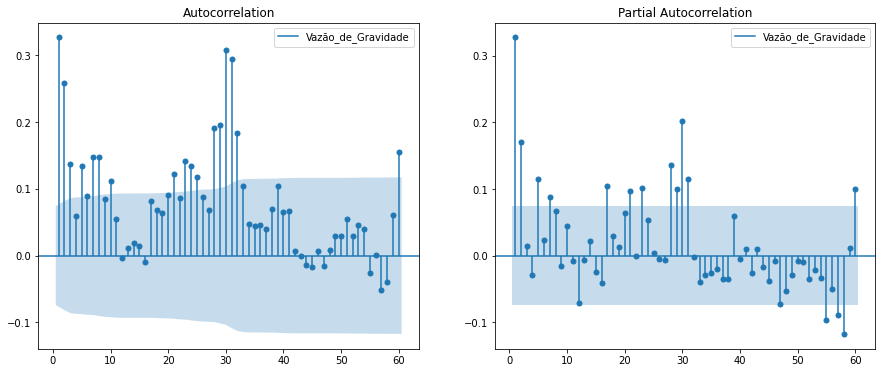

In [20]:
# Análise de auto correlação dos lags anteriores
fig, ax = plt.subplots(1,2,figsize=(15,6))
plot_acf(train['Vazao02'], lags=60, zero=False, ax=ax[0]);
plot_pacf(train['Vazao02'], lags=60, zero=False, ax=ax[1]);
ax[0].legend(["Vazão_de_Gravidade"], loc="upper right")
ax[1].legend(["Vazão_de_Gravidade"], loc="upper right")
plt.show()

In [21]:
#Rodar o ARIMA para os dados de treino, fazer forecast para o tamanho dos dados test
for t in range(len(test)):
    #model = ARIMA(history, order=(4,1,0))
    model = sm.tsa.statespace.SARIMAX(history, order=(4,1,0), seasonal_order=(4,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t,0]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
test['Predict'] = predictions

predicted=123.239693, expected=127.940000
predicted=123.215315, expected=112.300000
predicted=117.275710, expected=119.890000
predicted=120.182450, expected=129.610000
predicted=125.603635, expected=118.980000
predicted=124.406753, expected=124.100000
predicted=120.613144, expected=113.400000
predicted=118.699677, expected=124.130000
predicted=122.702320, expected=120.600000
predicted=121.366401, expected=126.240000
predicted=123.730823, expected=111.370000
predicted=116.079593, expected=126.410000
predicted=123.052256, expected=118.720000
predicted=120.082879, expected=117.100000
predicted=118.853833, expected=111.820000
predicted=115.241450, expected=111.450000
predicted=116.131150, expected=112.440000
predicted=112.172239, expected=108.700000
predicted=112.250280, expected=117.420000
predicted=114.900244, expected=127.380000
predicted=119.732537, expected=123.580000
predicted=119.991182, expected=120.330000
predicted=118.270358, expected=125.750000
predicted=121.926960, expected=124

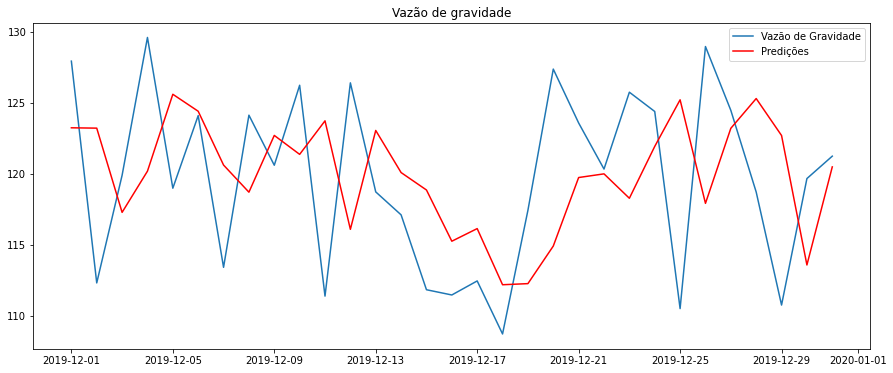

In [22]:
# Plotar a previsão e comparar com os testes
plt.figure(figsize=(15,6))
plt.plot(test['Vazao02'])
plt.plot(test['Predict'], color='red')
plt.title('Vazão de gravidade')
plt.legend(['Vazão de Gravidade', 'Predições'], loc="upper right")
plt.show()

In [23]:
# -----------------------------Função para analisar erros--------------------------------
def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = mean_absolute_percentage_error(orig, prev)
    
    grupo_erro = [mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie
    
def plotar_erro(dados, figsize=(15,6)):
    
    # Criando a coluna do erro
    dados['Erro'] = dados.iloc[:,0] - dados.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotando os valores reais e previstos
    ax1.plot(dados.iloc[:,0:2])
    ax1.legend(['Real','Prev'])
    ax1.set_title('Valores Reais vs Previstos')
    
    # Erro vs Valores previstos
    ax2.scatter(dados.iloc[:,1], dados.iloc[:,2])
    ax2.set_xlabel('Valores Previstos')
    ax2.set_ylabel('Resíduo')
    ax2.set_title('Resíduo vs Valores Previstos')
    
    ## QQ Plot do erro
    ax3.set_title('Gráfico QQ')
    sm.graphics.qqplot(dados.iloc[:,2], line='r', ax=ax3)
    
    # Gráfico de autocorrelação do Erro
    plot_acf(dados.iloc[:,2], lags=29, zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

MODELO ARIMA PARA O TREINO COMPARADO NA BASE DE TESTE


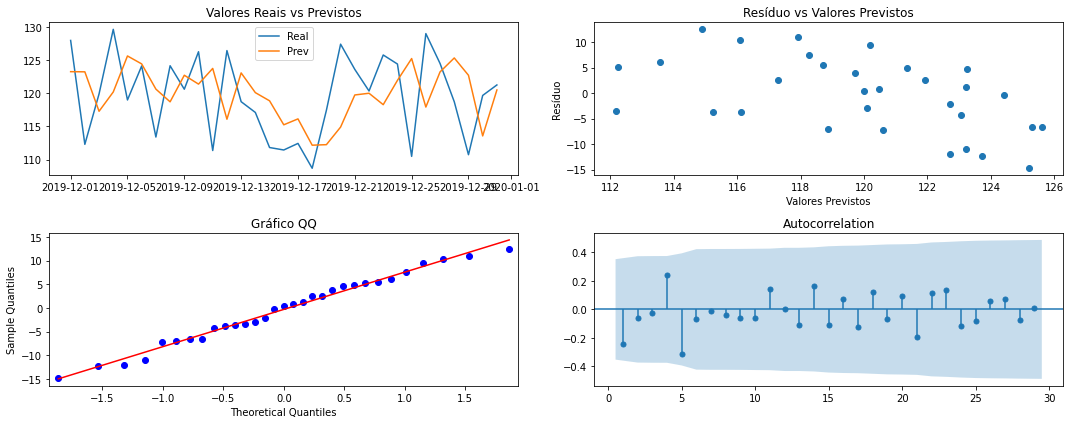

,Erros
Base Treino,
MSE,51.338664
RMSE,7.165100
MAE,6.013799
MAPE,0.050692


In [24]:
erro_teste = check_erro(test['Vazao02'], test['Predict'], nome_col='Erros',nome_indice='Base Treino')
print('MODELO ARIMA PARA O TREINO COMPARADO NA BASE DE TESTE')

plotar_erro(test)
erro_teste

<AxesSubplot:>

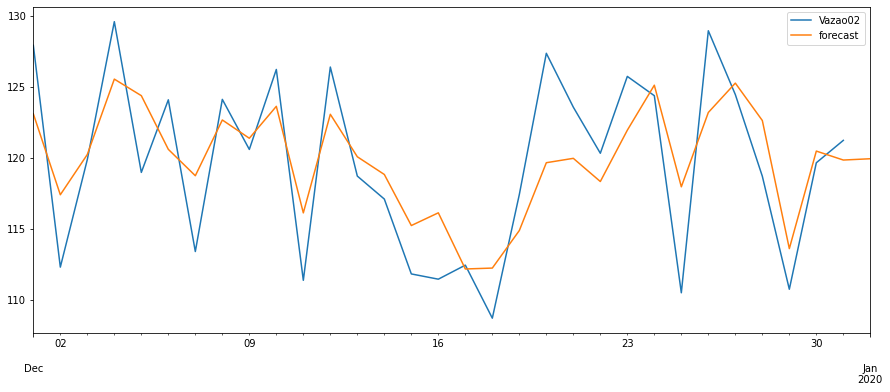

In [25]:
# Prevendo 1-step a frente

previsao = model_fit.predict(700,df['Vazao02'].count()+1,dynamic=False)

future_dates = [test.index[-1] + DateOffset(days = 2)for x in range(0,2)]
future_datest_df = pd.DataFrame(index = future_dates[1:], columns = test.columns)
future_datest_df.tail()

future_df = pd.concat([test,future_datest_df])
future_df.index = pd.date_range(start='2019-12-01', end='2020-01-01')
future_df['forecast'] = previsao
future_df[['Vazao02', 'forecast']].plot(figsize=(15, 6))


<AxesSubplot:>

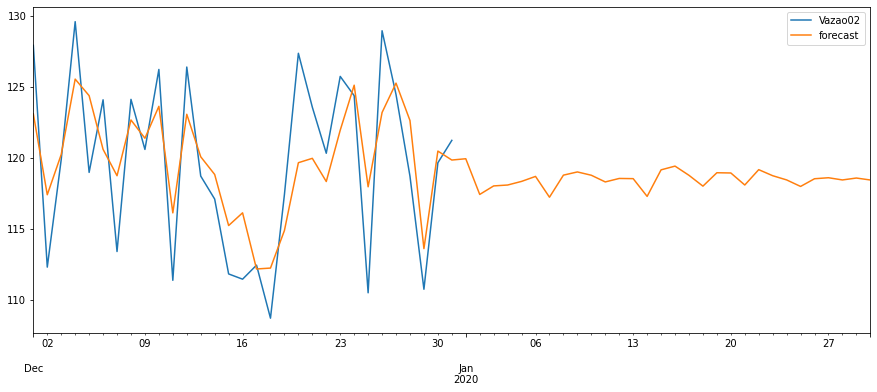

In [26]:
previsao = model_fit.predict(700,df['Vazao02'].count()+30,dynamic=False)

future_dates = [test.index[-1] + DateOffset(days = x)for x in range(0,31)]
future_datest_df = pd.DataFrame(index = future_dates[1:], columns = test.columns)
future_datest_df.tail()

future_df = pd.concat([test,future_datest_df])
future_df.index = pd.date_range(start='2019-12-01', end='2020-01-30')
future_df['forecast'] = previsao
future_df[['Vazao02', 'forecast']].plot(figsize=(15, 6))